## Project:
### Student: Kuzmich Aleksandra
### XAI, 2025

In [15]:
!pip install pytorch-tabnet --quiet


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Data preparation

### Load data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz", low_memory=False)

print("Shape:", df.shape)

Shape: (2260701, 151)


### Investigate structure

Columns with
>30% missing: 58 / 151
>50% missing: 44 / 151
>70% missing: 41 / 151


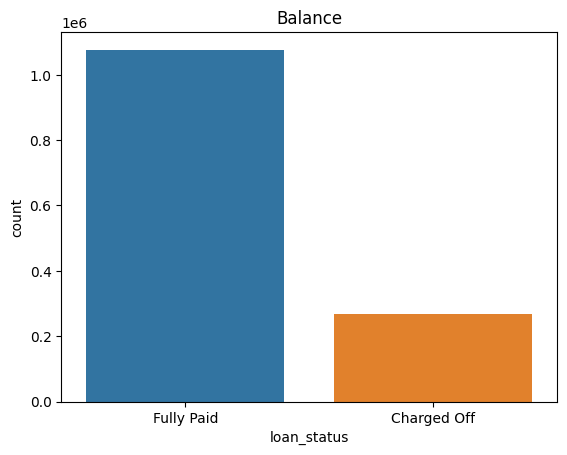

In [17]:
missing_ratio = df.isnull().mean()
total_cols = len(missing_ratio)

print("Columns with")
print(f">30% missing: {(missing_ratio > 0.3).sum()} / {total_cols}")
print(f">50% missing: {(missing_ratio > 0.5).sum()} / {total_cols}")
print(f">70% missing: {(missing_ratio > 0.7).sum()} / {total_cols}")

df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

sns.countplot(x='loan_status', data=df)
plt.title("Balance")
plt.xticks([0, 1], ['Fully Paid', 'Charged Off'])
plt.show()


### Make data convenient

In [18]:
threshold = 0.7 * len(df)  
df = df.dropna(thresh=threshold, axis=1)

drop_cols = ['id', 'member_id', 'emp_title', 'url', 'desc', 'title', 'zip_code']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
cat_cols = df.select_dtypes(include='object').columns.tolist()

df = df.fillna(df.median(numeric_only=True))  
df[cat_cols] = df[cat_cols].fillna("unknown")  

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


### Sample

In [19]:
from sklearn.model_selection import train_test_split

df, _ = train_test_split(
    df,
    train_size=20000,
    stratify=df['loan_status'],
    random_state=42
)
print("Shape:", df.shape)


Shape: (20000, 88)


### Normalize and split

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

target = 'loan_status'
X = df.drop(columns=[target]).values
y = df[target].values

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shape:")
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Shape:
Train: (14000, 87)
Val: (3000, 87)
Test: (3000, 87)


# Train model

TabNet model, suitable for table data

In [21]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

tabnet = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1,
    seed=42
)

tabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_val, y_val)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.58477 | val_accuracy: 0.789   |  0:00:00s
epoch 1  | loss: 0.38803 | val_accuracy: 0.78933 |  0:00:01s
epoch 2  | loss: 0.25635 | val_accuracy: 0.78967 |  0:00:01s
epoch 3  | loss: 0.18736 | val_accuracy: 0.79    |  0:00:02s
epoch 4  | loss: 0.1678  | val_accuracy: 0.792   |  0:00:03s
epoch 5  | loss: 0.15456 | val_accuracy: 0.79633 |  0:00:03s
epoch 6  | loss: 0.14978 | val_accuracy: 0.79433 |  0:00:04s
epoch 7  | loss: 0.1466  | val_accuracy: 0.799   |  0:00:04s
epoch 8  | loss: 0.14155 | val_accuracy: 0.798   |  0:00:05s
epoch 9  | loss: 0.13725 | val_accuracy: 0.82333 |  0:00:05s
epoch 10 | loss: 0.13198 | val_accuracy: 0.83767 |  0:00:06s
epoch 11 | loss: 0.12876 | val_accuracy: 0.76867 |  0:00:07s
epoch 12 | loss: 0.12472 | val_accuracy: 0.84433 |  0:00:07s
epoch 13 | loss: 0.11896 | val_accuracy: 0.811   |  0:00:08s
epoch 14 | loss: 0.11318 | val_accuracy: 0.83733 |  0:00:08s
epoch 15 | loss: 0.10289 | val_accuracy: 0.59433 |  0:00:09s
epoch 16 | loss: 0.09293

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### Report

Report:
              precision    recall  f1-score   support

  Fully Paid       1.00      0.95      0.97      2408
 Charged Off       0.82      0.99      0.90       592

    accuracy                           0.96      3000
   macro avg       0.91      0.97      0.93      3000
weighted avg       0.96      0.96      0.96      3000



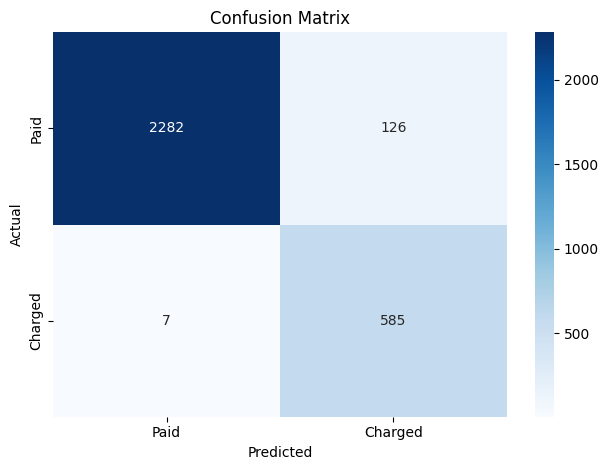

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds = tabnet.predict(X_test)
print("Report:")
print(classification_report(y_test, preds, target_names=['Fully Paid', 'Charged Off']))

cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Paid', 'Charged'], yticklabels=['Paid', 'Charged'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


# XAI part

Implementing approach for contrastive learning

## Generate contrastive explanation
Toy example for 1 instance

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

def generate_contrastive_explanation(index, df_explain, top_n=10):
    feature_cols = df_explain.drop(columns=['prediction', 'true_label']).columns.tolist()
    x = df_explain.loc[index, feature_cols].values.reshape(1, -1)
    x_class = df_explain.loc[index, 'prediction']

    opposite_class = 1 - x_class
    df_opposite = df_explain[df_explain['prediction'] == opposite_class]

    if df_opposite.empty:
        print("Error. No opposite.")
        return None

    X_opposite = df_opposite[feature_cols].values
    similarity_scores = cosine_similarity(x, X_opposite)[0]
    best_match_idx = df_opposite.iloc[np.argmax(similarity_scores)].name

    x_prime = df_explain.loc[best_match_idx, feature_cols]

    delta = np.abs(df_explain.loc[index, feature_cols] - x_prime)
    comparison = pd.DataFrame({
        'Target': df_explain.loc[index, feature_cols],
        'Contrast match': x_prime,
        'Difference': delta
    })

    explanation = comparison.sort_values(by='Difference', ascending=False).head(top_n)

    return explanation


In [25]:
all_preds = tabnet.predict(X)

df_explain = pd.DataFrame(X, columns=df.drop(columns=[target]).columns)
df_explain['prediction'] = all_preds
df_explain['true_label'] = y


index = df_explain[df_explain['prediction'] == 1].sample(1, random_state=42).index[0]

contrastive_result = generate_contrastive_explanation(index, df_explain, top_n=10)
display(contrastive_result)


,Target,Contrast match,Difference
verification_status,0.500000,1.000000,0.500000
acc_open_past_24mths,0.448276,0.103448,0.344828
num_tl_op_past_12m,0.421053,0.157895,0.263158
num_actv_rev_tl,0.363636,0.113636,0.250000
percent_bc_gt_75,0.750000,1.000000,0.250000
purpose,0.076923,0.307692,0.230769
num_bc_sats,0.270270,0.054054,0.216216
total_rec_prncp,0.085796,0.300000,0.214204
last_pymnt_amnt,0.008651,0.214185,0.205534
num_rev_tl_bal_gt_0,0.318182,0.113636,0.204545


## Generate explanations for batch

In [26]:
def batch_contrastive_explanations(df_explain, sample_class=1, sample_size=50, top_n=5):

    feature_counts = {}
    all_explanations = []
    
    candidates = df_explain[df_explain['prediction'] == sample_class]
    sampled_idxs = candidates.sample(sample_size, random_state=42).index

    for idx in sampled_idxs:
        result = generate_contrastive_explanation(idx, df_explain, top_n=top_n)
        if result is None:
            continue
        
        all_explanations.append(result)
        for feature in result.index[:top_n]:
            feature_counts[feature] = feature_counts.get(feature, 0) + 1

    return feature_counts, all_explanations


### Charged-off features

<Figure size 800x600 with 0 Axes>

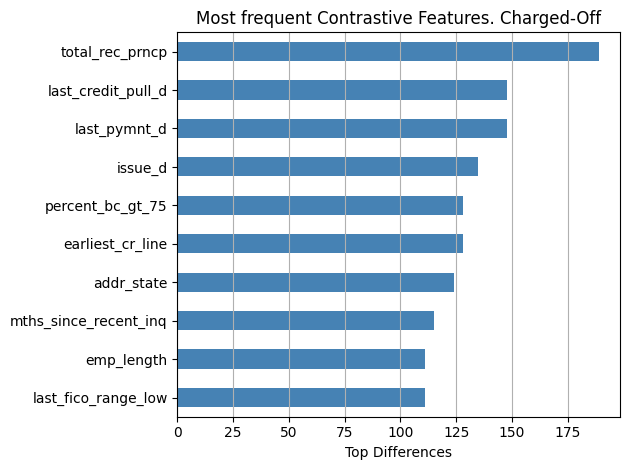

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

feature_counts, all_explanations = batch_contrastive_explanations(
    df_explain,
    sample_class=1,  
    sample_size=500, 
    top_n=5         
)

fc_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['count'])
fc_df = fc_df.sort_values(by='count', ascending=False).head(10).sort_values(by='count', ascending=True)


plt.figure(figsize=(8, 6))
fc_df.plot(kind='barh', legend=False, color='steelblue')
plt.title("Most frequent Contrastive Features. Charged-Off")
plt.xlabel("Top Differences")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


### Paid features

<Figure size 800x600 with 0 Axes>

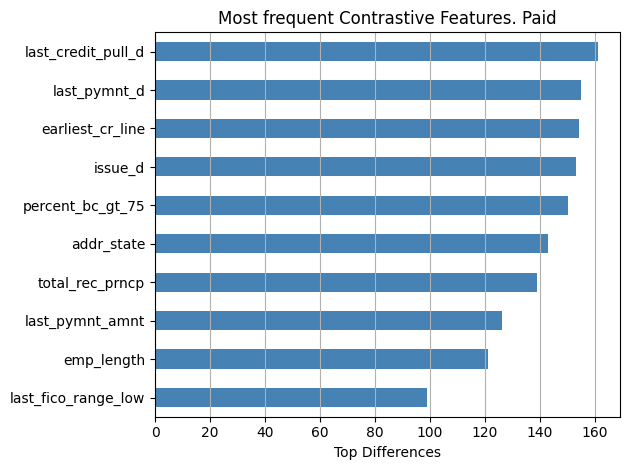

In [38]:
feature_counts_0, all_explanations_0 = batch_contrastive_explanations(
    df_explain,
    sample_class=0,  
    sample_size=500, 
    top_n=5         
)

fc_df_0 = pd.DataFrame.from_dict(feature_counts_0, orient='index', columns=['count'])
fc_df_0 = fc_df_0.sort_values(by='count', ascending=False).head(10).sort_values(by='count', ascending=True)


plt.figure(figsize=(8, 6))
fc_df_0.plot(kind='barh', legend=False, color='steelblue')
plt.title("Most frequent Contrastive Features. Paid")
plt.xlabel("Top Differences")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## Venn comparison

In [36]:
import pandas as pd
features_class_1 = set(feature_counts.keys())
features_class_0 = set(feature_counts_0.keys())

shared_features = features_class_1 & features_class_0
charged_only = features_class_1 - features_class_0
paid_only = features_class_0 - features_class_1

max_len = max(len(shared_features), len(charged_only), len(paid_only))

table = pd.DataFrame({
    'Charged-Off Only': list(charged_only) + [''] * (max_len - len(charged_only)),
    'Shared': list(shared_features) + [''] * (max_len - len(shared_features)),
    'Fully Paid Only': list(paid_only) + [''] * (max_len - len(paid_only))
})

display(table)


,Charged-Off Only,Shared,Fully Paid Only
0,debt_settlement_flag,percent_bc_gt_75,total_bc_limit
1,num_op_rev_tl,num_tl_30dpd,bc_open_to_buy
2,num_tl_90g_dpd_24m,pub_rec,application_type
3,,num_tl_op_past_12m,tot_coll_amt
4,,home_ownership,disbursement_method
...,...,...,...
57,,mo_sin_rcnt_rev_tl_op,
58,,mo_sin_old_il_acct,
59,,acc_open_past_24mths,
60,,mo_sin_old_rev_tl_op,


In [20]:
# feature_cols = df_explain.select_dtypes(include=[np.number]).drop(columns=['prediction', 'true_label']).columns.tolist()


# Fairness explanation

### Check fairness for income and verification status


In [39]:
inc_threshold = df_explain['annual_inc'].median()
df_explain['income_group'] = np.where(df_explain['annual_inc'] >= inc_threshold, 'High', 'Low')
df_explain['verification_status'] = df_explain['verification_status'].astype(str)

df_explain_numeric = df_explain.select_dtypes(include=[np.number]).copy()

df_explain_numeric['income_group'] = df_explain['income_group']
df_explain_numeric['verification_status'] = df_explain['verification_status']
df_explain_numeric['prediction'] = df_explain['prediction']
df_explain_numeric['true_label'] = df_explain['true_label']


### Generate contrastive explanations based on fairness attribute

In [40]:
def run_fairness_explanations(df_explain, group_col, sample_class=1, sample_size=500, top_n=5):
    
    group_feature_counts = {}
    groups = df_explain[group_col].unique()

    for group in groups:
        sub_df = df_explain[(df_explain[group_col] == group) & (df_explain['prediction'] == sample_class)]

        if len(sub_df) < sample_size:
            print(f"Skipping {group}")
            continue

        sampled = sub_df.sample(sample_size, random_state=42)
        feature_counts = {}

        for idx in sampled.index:
            result = generate_contrastive_explanation(idx, df_explain, top_n=top_n)
            if result is None:
                continue
            for feature in result.index:
                feature_counts[feature] = feature_counts.get(feature, 0) + 1

        group_feature_counts[group] = feature_counts

    return group_feature_counts


### Generate for a sample

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

def generate_contrastive_explanation(index, df_explain, top_n=10):
    
    feature_cols = df_explain.select_dtypes(include=[np.number]).drop(
        columns=['prediction', 'true_label'], errors='ignore'
    ).columns.tolist()

    x = df_explain.loc[index, feature_cols].values.reshape(1, -1)
    x_class = df_explain.loc[index, 'prediction']

    opposite_class = 1 - x_class
    df_opposite = df_explain[df_explain['prediction'] == opposite_class]

    if df_opposite.empty:
        print("No opposite-class")
        return None

    X_opposite = df_opposite[feature_cols].values
    similarity_scores = cosine_similarity(x, X_opposite)[0]
    best_match_idx = df_opposite.iloc[np.argmax(similarity_scores)].name

    x_prime = df_explain.loc[best_match_idx, feature_cols]
    delta = np.abs(df_explain.loc[index, feature_cols] - x_prime)

    explanation = pd.DataFrame({
        'Target': df_explain.loc[index, feature_cols],
        'Contrastive match': x_prime,
        'Difference': delta
    })

    return explanation.sort_values(by='Difference', ascending=False).head(top_n)


In [42]:
income_bias = run_fairness_explanations(df_explain_numeric, group_col='income_group', sample_class=1)
verif_bias = run_fairness_explanations(df_explain_numeric, group_col='verification_status', sample_class=1)


### Representation of features

In [45]:
def print_contrastive_feature_summary(bias_dict, df_explain, group_col, top_n=10, sample_class=1):
    for group, feats in bias_dict.items():
        n_samples = df_explain[
            (df_explain[group_col] == group) & (df_explain['prediction'] == sample_class)
        ].shape[0]

        print(f"\nTop contrastive features for group: {group}")
        sorted_feats = sorted(feats.items(), key=lambda x: -x[1])
        for feature, count in sorted_feats[:top_n]:
            print(f"- {feature}: {count}")


In [46]:
print_contrastive_feature_summary(income_bias, df_explain_numeric, group_col='income_group')
print_contrastive_feature_summary(verif_bias, df_explain_numeric, group_col='verification_status')



Top contrastive features for group: High
- total_rec_prncp: 210
- last_credit_pull_d: 155
- last_fico_range_low: 130
- issue_d: 129
- last_pymnt_d: 126
- earliest_cr_line: 126
- addr_state: 114
- percent_bc_gt_75: 105
- last_pymnt_amnt: 100
- emp_length: 85

Top contrastive features for group: Low
- issue_d: 170
- last_credit_pull_d: 159
- last_fico_range_low: 159
- earliest_cr_line: 148
- last_pymnt_d: 148
- percent_bc_gt_75: 138
- total_rec_prncp: 133
- addr_state: 124
- emp_length: 115
- revol_util: 106

Top contrastive features for group: 1.0
- total_rec_prncp: 206
- last_pymnt_d: 153
- last_credit_pull_d: 140
- issue_d: 138
- earliest_cr_line: 131
- addr_state: 121
- emp_length: 115
- last_fico_range_low: 114
- percent_bc_gt_75: 107
- last_pymnt_amnt: 98

Top contrastive features for group: 0.5
- total_rec_prncp: 194
- last_pymnt_d: 150
- last_fico_range_low: 146
- last_credit_pull_d: 146
- issue_d: 146
- earliest_cr_line: 127
- addr_state: 114
- emp_length: 104
- mths_since_rece

# Greedy counterfactual

### Greedy by pertrubing features

In [58]:
def greedy_counterfactual_search(
    x_orig, model, feature_names, feature_ranges,
    step_size=0.05, max_steps=20, flip_target=None
):
    
    x_cf = x_orig.copy()
    original_pred = model.predict(x_orig.reshape(1, -1))[0]
    if flip_target is None:
        flip_target = 1 - original_pred

    print(f"Original: {original_pred} | Target: {flip_target}")
    changes = []

    for i, feature in enumerate(feature_names):
        original_val = x_orig[i]
        step_range = feature_ranges[i]

        for direction in [+1, -1]:
            for step in range(1, max_steps + 1):
                delta = direction * step_size * step * step_range
                new_val = original_val + delta
                new_val = np.clip(new_val, 0.0, 1.0)  

                x_try = x_cf.copy()
                x_try[i] = new_val
                new_pred = model.predict(x_try.reshape(1, -1))[0]

                if new_pred == flip_target:
                    changes.append((feature, original_val, new_val))
                    x_cf[i] = new_val
                    break

            if model.predict(x_cf.reshape(1, -1))[0] == flip_target:
                break

        if model.predict(x_cf.reshape(1, -1))[0] == flip_target:
            break

    return changes, x_cf


In [60]:
feature_names = df.drop(columns=[target]).columns.tolist()
feature_ranges = X_train.max(axis=0) - X_train.min(axis=0)
idx = 0
x = X_test[idx]
changes, x_cf = greedy_counterfactual_search(x, tabnet, feature_names, feature_ranges)


Original: 0 | Target: 1


### Run on multiple

In [64]:
def batch_counterfactual_analysis(X, model, feature_names, feature_ranges, sample_class=0, sample_size=100):

    sample_idxs = np.where(model.predict(X) == sample_class)[0]
    sample_idxs = np.random.choice(sample_idxs, min(len(sample_idxs), sample_size), replace=False)

    changes_per_sample = []
    changed_features = []

    for idx in sample_idxs:
        x = X[idx]
        changes, _ = greedy_counterfactual_search(x, model, feature_names, feature_ranges, flip_target=1-sample_class)
        changes_per_sample.append(len(changes))
        changed_features.extend([feat for feat, _, _ in changes])

    return changes_per_sample, changed_features


Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1
Original: 0 | Target: 1


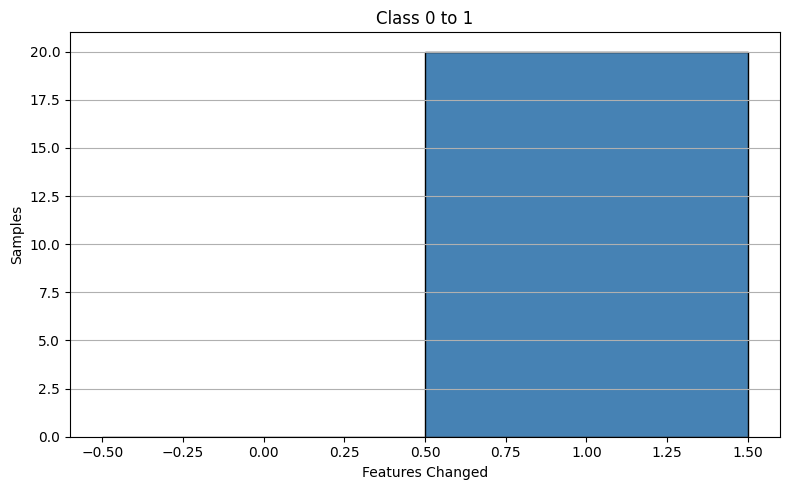

Average features changed: 1.00
Total flipped: 20 / 20
Unflippable: 0

Most frequently changed features to flip predictions:
• loan_amnt: 12 times
• total_pymnt: 5 times
• total_rec_prncp: 1 times
• collection_recovery_fee: 1 times
• recoveries: 1 times


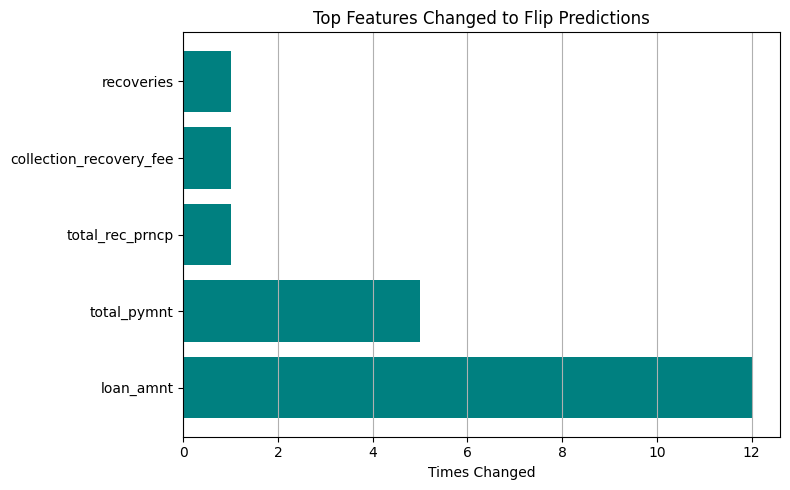

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

changes_list, changed_feats = batch_counterfactual_analysis(
    X_test, tabnet, feature_names, feature_ranges,
    sample_class=0, sample_size=20
)

plt.figure(figsize=(8, 5))
plt.hist(changes_list, bins=range(0, max(changes_list) + 2), color='steelblue', edgecolor='black', align='left')
plt.xlabel("Features Changed")
plt.ylabel("Samples")
plt.title("Class 0 to 1")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print(f"Average features changed: {np.mean(changes_list):.2f}")
print(f"Total flipped: {np.sum([c > 0 for c in changes_list])} / {len(changes_list)}")
print(f"Unflippable: {np.sum([c == 0 for c in changes_list])}")

feat_counts = Counter(changed_feats)
top_feats = feat_counts.most_common(10)

print("\nMost frequently changed features to flip predictions:")
for feat, count in top_feats:
    print(f"• {feat}: {count} times")

feats, counts = zip(*top_feats)
plt.figure(figsize=(8, 5))
plt.barh(feats, counts, color='teal')
plt.xlabel("Times Changed")
plt.title("Top Features Changed to Flip Predictions")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


# SHAP

### Approximate shap values using sampling over subsets

In [69]:
import numpy as np
from tqdm import trange  

def mask_input(x, mask, baseline):
    return mask * x + (1 - mask) * baseline

def shap_values(model, x, baseline, num_samples=100):

    n_features = x.shape[0]
    shap_vals = np.zeros(n_features)

    for i in trange(n_features, desc="Computing Shap"):
        contributions = []
        for _ in range(num_samples):
            included = np.random.choice([0, 1], size=n_features)
            included[i] = 0
            
            x_S = mask_input(x, included, baseline)
            included[i] = 1
            x_Si = mask_input(x, included, baseline)

            f_S = model(x_S.reshape(1, -1))[0]
            f_Si = model(x_Si.reshape(1, -1))[0]

            contributions.append(f_Si - f_S)

        shap_vals[i] = np.mean(contributions)

    return shap_vals


### On one entry

In [70]:
from tqdm import tqdm 

x = X_test[0]
baseline = X_train.mean(axis=0)

def model_fn(x_input):
    return tabnet.predict(x_input)

shap_vals = shap_values(model_fn, x, baseline, num_samples=100)


Computing Shap: 100%|██████████| 87/87 [02:25<00:00,  1.68s/it]


In [71]:
top_idxs = np.argsort(np.abs(shap_vals))[::-1][:15]
for i in top_idxs:
    print(f"{feature_names[i]}: SHAP = {shap_vals[i]:.4f}")

funded_amnt: SHAP = 0.0500
last_pymnt_amnt: SHAP = -0.0400
total_pymnt: SHAP = -0.0300
application_type: SHAP = 0.0300
last_pymnt_d: SHAP = 0.0300
mths_since_recent_inq: SHAP = 0.0300
home_ownership: SHAP = -0.0300
total_rec_prncp: SHAP = -0.0200
num_rev_tl_bal_gt_0: SHAP = -0.0200
last_fico_range_high: SHAP = -0.0200
loan_amnt: SHAP = 0.0200
last_fico_range_low: SHAP = 0.0200
total_pymnt_inv: SHAP = -0.0100
term: SHAP = -0.0100
collection_recovery_fee: SHAP = -0.0100


### Split into pushin towards approve or reject

In [76]:
def explain_shap_values(shap_vals, feature_names, top_k=15):

    shap_info = list(zip(feature_names, shap_vals))
    shap_info_sorted = sorted(shap_info, key=lambda x: -abs(x[1]))[:top_k]

    print("\nFeatures toward approval:")
    for feat, val in shap_info_sorted:
        if val < 0:
            print(f"- {feat}: SHAP = {val:.4f}")

    print("\nFeatures toward rejection:")
    for feat, val in shap_info_sorted:
        if val > 0:
            print(f"- {feat}: SHAP = {val:.4f}")


In [77]:
explain_shap_values(shap_vals, feature_names)


Features toward approval:
- last_pymnt_amnt: SHAP = -0.0400
- home_ownership: SHAP = -0.0300
- total_pymnt: SHAP = -0.0300
- total_rec_prncp: SHAP = -0.0200
- last_fico_range_high: SHAP = -0.0200
- num_rev_tl_bal_gt_0: SHAP = -0.0200
- term: SHAP = -0.0100
- grade: SHAP = -0.0100

Features toward rejection:
- funded_amnt: SHAP = 0.0500
- last_pymnt_d: SHAP = 0.0300
- application_type: SHAP = 0.0300
- mths_since_recent_inq: SHAP = 0.0300
- loan_amnt: SHAP = 0.0200
- last_fico_range_low: SHAP = 0.0200
- issue_d: SHAP = 0.0100


### Fairness in regards income and verification

In [82]:
def group_shap_summary(X, group_col, group_labels, model_fn, baseline, feature_names, num_samples=1, top_k=10):

    from collections import defaultdict
    import numpy as np

    unique_groups = np.unique(group_labels)
    group_shap_means = {}

    for group in unique_groups:
        idxs = np.where(group_labels == group)[0]
        group_shaps = []

        print(f"\nGroup: {group}")
        for idx in idxs[:num_samples]:
            x = X[idx]
            shap_vals = shap_values(model_fn, x, baseline)
            group_shaps.append(shap_vals)

        mean_vals = np.mean(group_shaps, axis=0)
        group_shap_means[group] = mean_vals

        top_idxs = np.argsort(np.abs(mean_vals))[::-1][:top_k]
        print("Top features:")
        for i in top_idxs:
            print(f"- {feature_names[i]}: {mean_vals[i]:+.4f}")


    return group_shap_means


In [83]:
income_group = df_explain_numeric["income_group"].values
verification_status = df_explain_numeric["verification_status"].values


baseline = X_train.mean(axis=0)
model_fn = lambda x: tabnet.predict(x)

print("Shap fairness by income group")
_ = group_shap_summary(X_test, "income_group", income_group, model_fn, baseline, feature_names, num_samples=1)

print("\n Shap fairness by verification status")
_ = group_shap_summary(X_test, "verification_status", verification_status, model_fn, baseline, feature_names)


Shap fairness by income group

Group: High


Computing Shap: 100%|██████████| 87/87 [02:23<00:00,  1.65s/it]


Top features:
- last_pymnt_amnt: -0.0800
- total_rec_prncp: -0.0600
- total_pymnt: -0.0500
- issue_d: +0.0300
- collection_recovery_fee: -0.0200
- application_type: +0.0200
- loan_amnt: +0.0200
- addr_state: +0.0100
- num_rev_tl_bal_gt_0: -0.0100
- num_tl_90g_dpd_24m: -0.0100

Group: Low


Computing Shap: 100%|██████████| 87/87 [02:23<00:00,  1.65s/it]


Top features:
- initial_list_status: +0.0200
- debt_settlement_flag: -0.0100
- mo_sin_old_rev_tl_op: +0.0100
- issue_d: -0.0100
- pub_rec: +0.0000
- revol_bal: +0.0000
- revol_util: +0.0000
- total_acc: +0.0000
- out_prncp: +0.0000
- out_prncp_inv: +0.0000

 Shap fairness by verification status

Group: 0.0


Computing Shap: 100%|██████████| 87/87 [02:23<00:00,  1.65s/it]


Top features:
- total_pymnt: -0.1300
- total_rec_prncp: -0.1100
- last_pymnt_amnt: -0.1000
- loan_amnt: +0.0800
- funded_amnt: +0.0700
- last_fico_range_high: -0.0700
- collection_recovery_fee: -0.0500
- term: -0.0500
- application_type: -0.0500
- total_pymnt_inv: -0.0500

Group: 0.5


Computing Shap: 100%|██████████| 87/87 [02:23<00:00,  1.65s/it]


Top features:
- num_actv_bc_tl: +0.0100
- mo_sin_old_rev_tl_op: -0.0100
- total_pymnt_inv: -0.0100
- pub_rec: -0.0100
- funded_amnt: +0.0100
- revol_bal: +0.0000
- revol_util: +0.0000
- total_acc: +0.0000
- initial_list_status: +0.0000
- out_prncp: +0.0000

Group: 1.0


Computing Shap: 100%|██████████| 87/87 [02:23<00:00,  1.65s/it]

Top features:
- last_pymnt_amnt: -0.0600
- total_rec_prncp: -0.0500
- total_pymnt: -0.0400
- issue_d: +0.0300
- application_type: +0.0300
- total_pymnt_inv: -0.0300
- mo_sin_old_il_acct: -0.0200
- mths_since_recent_inq: +0.0200
- total_il_high_credit_limit: +0.0200
- funded_amnt_inv: +0.0200
